# Load Libraries

In [67]:
# Uncomment to install PyWavelets and dtcwt
# !pip3 install PyWavelets
# !pip3 install dtcwt

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cv2
from PIL import Image
import os

# For semantic segmentation
import torch
import torchvision
from torchvision import transforms
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights

from skimage import io, color, img_as_float
from scipy.ndimage import gaussian_filter

from skimage.morphology import opening, closing, disk
from skimage import io, color, img_as_float, morphology
from scipy.ndimage import gaussian_filter
from scipy import ndimage as ndi

import pywt
import dtcwt
import csv
import pickle

print(np.__version__)

1.26.4


# Image Read

In [69]:
# read image of any format - png, bmp, jpg and return the rgb image as numpy array
# normalize the image to [0, 1] range
def read_img(image_path):
    img = Image.open(image_path)
    img = np.array(img)
    img = img / 255.0
    return img

# Segmentation - KMeans and Semantic

In [70]:
def kmeans(img, n_clusters, display=False):
    data = img.reshape((-1, 1))
    H, W = img.shape

    kmeans = KMeans(n_clusters=n_clusters, n_init='auto')
    clusters = kmeans.fit_predict(data)
    clusters = clusters.reshape((H, W))

    if display:
        plt.imshow(clusters, cmap="Spectral")
        plt.title(f"Input Image Segmentation, n_clusters: {n_clusters}")
        plt.axis('off')
        plt.show()

    return clusters

In [71]:
def simple_segmentation(image, n_clusters=5, feature_space='rgb', smoothing_sigma=1,display=False):
    """
    Perform simple image segmentation using K-means clustering.

    Parameters:
    - image: Input image as a NumPy array.
    - n_clusters: The desired number of clusters (segments).
    - feature_space: The color space to use ('rgb' or 'lab').

    Returns:
    - labels: A 2D array of the same height and width as the image, containing the segment labels.
    """
    # Convert image to float representation
    image = img_as_float(image)
    h, w, c = image.shape

    # Apply image smoothing to reduce noise
    smoothed_image = gaussian_filter(image, sigma=(smoothing_sigma, smoothing_sigma, 0))

    # Choose feature space
    if feature_space == 'lab':
        # Convert to Lab color space for better perceptual similarity
        image_feats = color.rgb2lab(smoothed_image)
    else:
        # Use RGB color space
        image_feats = smoothed_image

    # Reshape the image to a 2D array of pixels and color features
    X = image_feats.reshape((-1, c))

    # Perform K-means clustering
    print("Performing K-means clustering...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_

    # Reshape labels back to image dimensions
    labels = labels.reshape((h, w))

    # Apply improved morphological operations to clean up small regions
    selem = morphology.disk(5)
    labels_cleaned = np.zeros_like(labels)
    min_size = 500  # Adjust this value based on image size

    for i in range(n_clusters):
        mask = (labels == i).astype(np.bool_)
        mask_filled = ndi.binary_fill_holes(mask)
        mask_cleaned = morphology.remove_small_objects(mask_filled, min_size=min_size)
        mask_smooth = morphology.closing(mask_cleaned, selem)
        mask_smooth = morphology.opening(mask_smooth, selem)
        labels_cleaned[mask_smooth] = i

    if display:
        plt.imshow(labels_cleaned, cmap='tab20')
        plt.axis('off')
        plt.title('Segmentation Result')
        plt.show()

    return labels_cleaned


# Band Processing

In [72]:
# Performs Log Normalization and z-tranforms and clips data [-1, 2] range
def normalize_coeffs(bands):
    reals = []
    imags = []
    for band in range(bands.shape[-1]):
        real_coeffs = bands[:, :, band].real
        imag_coeffs = bands[:, :, band].imag

        # Normalize
        # Log (1+x) transform
        eps = 1e-8
        real_coeffs = np.log10((real_coeffs) + abs(real_coeffs.min()) + eps)
        imag_coeffs = np.log10((imag_coeffs) + abs(imag_coeffs.min()) + eps)

        # Z-Scaling
        real_coeffs = (real_coeffs - real_coeffs.mean()) / (real_coeffs.std() + 1e-8)
        imag_coeffs = (imag_coeffs - imag_coeffs.mean()) / (imag_coeffs.std() + 1e-8)

        reals.append(real_coeffs)
        imags.append(imag_coeffs)

    return np.asarray(reals), np.asarray(imags)

In [73]:
def display_wavelet_coeffs(reals, imags, display=False, savepath=""):
    # Clip the data to [-1, 2] range
    reals = np.clip(reals, -1, 2)
    imags = np.clip(imags, -1, 2)
    if display:
        plt.figure(figsize=(12, 4))
        for i, data in enumerate(zip(reals, imags)):
            real, imag = data

            plt.subplot(2, 6, i + 1)
            plt.imshow(real, cmap="Spectral")
            plt.title(f"Real, Band{i+1}")
            plt.axis('off')

            plt.subplot(2, 6, i + 7)
            plt.imshow(imag, cmap="Spectral")
            plt.title(f"Imag, Band{i+1}")
            plt.axis('off')

        plt.suptitle("Level 1, Real and Imaginary Bands 1-6")

        if savepath != "":
            plt.savefig(f"{savepath}_bands.png")

        plt.show()

In [74]:
def get_patch_mean_variance(band, patch_size):
    H, W = band.shape
    patch_means = []
    for h in range(0, H, patch_size):
        for w in range(0, W, patch_size):
            patch = band[h:h+patch_size, w:w+patch_size]
            patch_means.append(np.mean(patch))

    var = np.var(patch_means)
    return var

In [75]:
def get_band_variance(mask, reals, imags, patch_size):
    real_var = []
    imag_var = []
    for real, imag in zip(reals, imags):
        # Real first
        band = mask * real
        real_var.append(get_patch_mean_variance(band, patch_size))
        
        # Imag
        band = mask * imag
        imag_var.append(get_patch_mean_variance(band, patch_size))

    return np.asarray(real_var), np.asarray(imag_var)

In [76]:
def compute_threshold_dynamic(mask, real_coeffs, imag_coeffs, patch_size):
    var_reals, var_imag = get_band_variance(mask, real_coeffs, imag_coeffs, patch_size)
    var = np.concatenate((var_imag, var_reals))
    var = np.percentile(var, 95)
    return var

# Wavelets

In [77]:
# Return the coeffs of the DT-CWT transform
def wavelet_dtcwt(img):
    assert len(img.shape) == 2, "Not a grayscale image"

    # Initialize the DTCWT transform
    transform = dtcwt.Transform2d()

    # Perform the DTCWT on the image with only 1 level
    coeffs = transform.forward(img, nlevels=1)
    return coeffs.highpasses[0]


In [78]:
def wavelet_general(img, wavelet_type='haar'):

    if wavelet_type == 'dtcwt':
        return wavelet_dtcwt(img)

    LL, (LH, HL, HH) = pywt.dwt2(img, wavelet_type)
    print(LH.shape)
    H, W = LH.shape

    coeffs = np.zeros((H, W, 3))
    coeffs[:, :, 0] = LH
    coeffs[:, :, 1] = HL
    coeffs[:, :, 2] = HH

    return coeffs

# Noise Models


In [79]:
def noise_zero(img):
    return np.zeros_like(img)

# Noise Variance Method

In [80]:
def im2patch(im, pch_size, stride=1):
    '''
    Transform image to patches.
    Input:
        im: 3 x H x W or 1 X H x W image, numpy format
        pch_size: (int, int) tuple or integer
        stride: (int, int) tuple or integer
    '''
    if isinstance(pch_size, tuple):
        pch_H, pch_W = pch_size
    elif isinstance(pch_size, int):
        pch_H = pch_W = pch_size
    else:
        print('The input of pch_size must be a integer or a int tuple!')

    if isinstance(stride, tuple):
        stride_H, stride_W = stride
    elif isinstance(stride, int):
        stride_H = stride_W = stride
    else:
        print('The input of stride must be a integer or a int tuple!')


    C, H, W = im.shape
    num_H = len(range(0, H-pch_H+1, stride_H))
    num_W = len(range(0, W-pch_W+1, stride_W))
    num_pch = num_H * num_W
    pch = np.zeros((C, pch_H*pch_W, num_pch), dtype=im.dtype)
    kk = 0
    for ii in range(pch_H):
        for jj in range(pch_W):
            temp = im[:, ii:H-pch_H+ii+1:stride_H, jj:W-pch_W+jj+1:stride_W]
            pch[:, kk, :] = temp.reshape((C, num_pch))
            kk += 1

    return pch.reshape((C, pch_H, pch_W, num_pch))

In [81]:
def noise_estimate(im, pch_size=8):
    '''
    Implement of noise level estimation of the following paper:
    Chen G , Zhu F , Heng P A . An Efficient Statistical Method for Image Noise Level Estimation[C]// 2015 IEEE International Conference
    on Computer Vision (ICCV). IEEE Computer Society, 2015.
    Input:
        im: the noise image, H x W x 3 or H x W numpy tensor, range [0,1]
        pch_size: patch_size
    Output:
        noise_level: the estimated noise level
    '''

    if im.ndim == 3:
        im = im.transpose((2, 0, 1))
    else:
        im = np.expand_dims(im, axis=0)

    # image to patch
    pch = im2patch(im, pch_size, 3)  # C x pch_size x pch_size x num_pch tensor
    num_pch = pch.shape[3]
    pch = pch.reshape((-1, num_pch))  # d x num_pch matrix
    d = pch.shape[0]

    mu = pch.mean(axis=1, keepdims=True)  # d x 1
    X = pch - mu
    sigma_X = np.matmul(X, X.transpose()) / num_pch
    sig_value, _ = np.linalg.eigh(sigma_X)
    sig_value.sort()

    for ii in range(-1, -d-1, -1):
        tau = np.mean(sig_value[:ii])
        if np.sum(sig_value[:ii]>tau) == np.sum(sig_value[:ii] < tau):
            return np.sqrt(tau)

# Filtering

In [82]:
# normalise the output between [0,1]
def small_median_filter_residue(band, kernel_size):
    median_blur = cv2.medianBlur(band, ksize=kernel_size)
    first_diff = band - median_blur
    second_diff = cv2.medianBlur(first_diff, ksize=kernel_size)
    band = band - second_diff
    band = (band - band.min()) / (band.max() - band.min())
    return band

In [83]:
def wiener_filter(band, kernel_size=3, noise_variance=0.1):
    local_mean = cv2.blur(band, (kernel_size, kernel_size))
    local_variance = cv2.blur((band - local_mean) ** 2, (kernel_size, kernel_size))
    wiener_filtered = local_mean + (local_variance - noise_variance) / (local_variance + 1e-8) * (band - local_mean)
    return np.clip(wiener_filtered, 0, 1)  # Clipping to avoid overflow

In [84]:
from skimage import restoration
from scipy.signal import convolve2d

# normalise the output between [0,1]
def wiener_filter_updated(img):
    psf = np.ones((5, 5)) / 25
    img = convolve2d(img, psf, 'same')
    rng = np.random.default_rng()
    img += 0.1 * img.std() * rng.standard_normal(img.shape)
    deconvolved_img = restoration.wiener(img, psf, 0.1)
    deconvolved_img = (deconvolved_img - deconvolved_img.min()) / (deconvolved_img.max() - deconvolved_img.min())
    return deconvolved_img

In [85]:
# normalise the output between [0,1]
def median_modified_wiener_filter(band, kernel_size=3, noise_variance=0.1):
    # Step 1: Apply median filter
    median_filtered = cv2.medianBlur(band, kernel_size)
    # Step 2: Apply Wiener filter to median-filtered band
    # wiener_filtered = wiener_filter(median_filtered, kernel_size, noise_variance)
    wiener_filtered = wiener_filter_updated(median_filtered)
    wiener_filtered = (wiener_filtered - wiener_filtered.min()) / (wiener_filtered.max() - wiener_filtered.min())
    return wiener_filtered

In [86]:
def get_mask_from_releavant_bands(bands, kernel_size, display=False):
    if len(bands) == 0:
        print("No bands available. Adjust threshold maybe.")
        return 0

    final_mask = np.zeros_like(bands[0])
    for band in bands:
        band = band.astype(np.float32)
        median_filtered = cv2.medianBlur(band, ksize=kernel_size)
        
        # normalise the output between [0,1]
        median_filtered = (median_filtered - median_filtered.min()) / (median_filtered.max() - median_filtered.min())

        smfr_filtered = small_median_filter_residue(band, kernel_size=kernel_size) 
        # wiener_filtered = wiener_filter(band, kernel_size=kernel_size)
        wiener_filtered = wiener_filter_updated(band)
        median_modified_wiener_filtered = median_modified_wiener_filter(band, kernel_size=kernel_size)

        # filters = [median_filtered, smfr_filtered, wiener_filtered, median_modified_wiener_filtered]
        filters = [median_filtered, smfr_filtered, wiener_filtered, median_modified_wiener_filtered]

        #display filtered images
        if display:
            plt.figure(figsize=(12, 4))
            for i, filter_img in enumerate(filters):
                filter_img_clipped = np.clip(filter_img, -1, 2)
                plt.subplot(1, 4, i + 1)
                plt.imshow(filter_img_clipped, cmap="Spectral")
                plt.title(f"Filter {i+1}")
                plt.axis('off')
                plt.colorbar()
            plt.suptitle("Filtered Images")
            plt.show()

        # noise estimate for the band 
        # largest_noise_estimate = noise_estimate(band, 8)

        avg_filter = np.zeros_like(median_filtered)
        for filter_img in filters:
            avg_filter += filter_img
        avg_filter /= len(filters)
        if display:
            avg_filter_clipped = np.clip(avg_filter, -1, 2)
            plt.imshow(avg_filter_clipped, cmap="Spectral")
            plt.title("Average Filter")
            plt.colorbar()
            plt.axis('off')
            plt.show()


        for filter_img in [avg_filter]:
            filtered_clusters = kmeans(filter_img, n_clusters=3, display=display)

            largest_noise_clus = None
            largest_noise_estimate = 1e-32
            # max_noise = -1e32
            for clus in list(np.unique(filtered_clusters)):
            #     internal_mask = (filtered_clusters == clus).astype(np.int8)
            #     noise = (band - filter_img) * internal_mask
            #     noise_range = noise.max() - noise.min()
                noise_est = noise_estimate(band, 8)
                if noise_est > largest_noise_estimate:
                    largest_noise_clus = clus
                    largest_noise_estimate = noise_est

            assert largest_noise_clus != None

            # display the lowest noise cluster
            if display:
                plt.imshow(filtered_clusters == largest_noise_clus)
                plt.title("Largest Noise Cluster")
                plt.colorbar()
                plt.axis('off')
                plt.show()

            final_mask += (filtered_clusters == largest_noise_clus).astype(np.int8)

    return final_mask

# Wrapper Function

In [ ]:
def detect_inpainting(file_path, 
                      wavelet_type, 
                      noise_func, 
                      output_path,
                      loaded_detections,
                      patch_size=16, 
                      var_threshold='dynamic', 
                      kernel_size=3, 
                      segmentation_method='sam', 
                      display=False):
    # Read Image
    img = read_img(file_path)
    
    # Display Input Image
    if display:
        plt.imshow(img)
        plt.axis('off')
        plt.title("Input Image")
        plt.show()
        print("Image Shape ", img.shape)

    # Convert to grayscale
    gray_img = img.mean(axis=2)
    H, W = gray_img.shape

    # Display Gray Image
    if display:
        plt.imshow(gray_img, cmap="gray")
        plt.axis('off')
        plt.title("Gray Image")
        plt.show()

    # clusters = semantic_segmentation(img, n_clusters=1, display=True)
    clusters = None
    if segmentation_method == 'kmeans':
        clusters = simple_segmentation(img, n_clusters=4, feature_space='rgb', display=display, smoothing_sigma=1)
    elif segmentation_method == "sam":
        assert loaded_detections != None, "Loaded Detections are not passed"
        masks = loaded_detections["masks"]
        scores = loaded_detections["scores"]
        bounding_boxes = loaded_detections["bounding_boxes"]

        segments = np.zeros((H, W), dtype=int)

        for i, mask in enumerate(masks):
            # Ensure the mask is binary and within bounds
            mask = mask.astype(int)

            # Add the mask to the `segments` array with a unique label
            segments[mask == 1] = i + 1  # Use `i + 1` to avoid overlapping with background (0)

        # Perform segmentation
        clusters = segments
        if display:
            plt.imshow(clusters, cmap="tab20")
            plt.axis('off')
            plt.title('Segmentation Result')
            plt.show()

    # TODO: Check if this is correct
    # We are W/2 and H/2 because the bands are of this size. But is this correct?
    # assert clusters != None
    clusters = clusters[::2, ::2]

    # Add Noise TODO: Check if this is the right place to add noise
    noise = noise_func(gray_img)
    gray_img += noise

    # DTCWT on grayscale image
    wavelet_coeffs = wavelet_general(gray_img, wavelet_type=wavelet_type) 
    print("Wavelet Coeffs Shape: ", wavelet_coeffs.shape)
    ##########################
    # IMPORTANT: wavelet_coeffs has to of the shape [H/2, W/2, bands]
    ##########################
    # assert wavelet_coeffs.shape == ((H+1)//2, (W+1)//2, 6), f"wavelet_coeffs is of shape: {wavelet_coeffs.shape}, but it's supposed to be {((H+1)//2, (W+1)//2, 6)}"

    # Normalize
    real_coeffs, imag_coeffs = normalize_coeffs(wavelet_coeffs)

    # Display Normalized and Clipped Wavelet Coefficients
    display_wavelet_coeffs(real_coeffs, imag_coeffs, display=display, savepath=output_path)

    final_mask = np.zeros_like(real_coeffs[0]) # TODO: Put correct shape here

    relavant_band_real = []
    relavant_band_imag = []

    for cluster in list(np.unique(clusters)):
        mask = (clusters == cluster).astype(np.int8)

        #pad the mask to make it equal to the size of the bands
        pad_x = (real_coeffs[0].shape[0] - mask.shape[0])
        pad_y = (real_coeffs[0].shape[1] - mask.shape[1])
        mask = np.pad(mask, ((pad_x//2, pad_x-(pad_x//2)), (pad_y//2, pad_y-(pad_y//2))), 'constant', constant_values=(0, 0))

        #display mask
        if display:
            plt.imshow(mask, cmap="gray")
            plt.axis('off')
            plt.title("Mask Image")
            plt.show()
        
        real_vars, imag_vars = get_band_variance(mask, real_coeffs, imag_coeffs, patch_size=patch_size)

        print("Real Vars: ", real_vars)
        print("Imag Vars: ", imag_vars)

        # if (np.all(real_vars < 1e-3) and np.all(imag_vars < 1e-3)):
        #     print("No relevant bands for this cluster found. Skipping...")
        #     continue

        real_vars_norm = (real_vars - real_vars.min()) / (real_vars.max() - real_vars.min())
        imag_vars_norm = (imag_vars - imag_vars.min()) / (imag_vars.max() - imag_vars.min())

        has_nan = np.any(np.isnan(imag_vars_norm))
        n_bands = real_vars_norm.shape[0]
        if has_nan:
            imag_vars_norm = np.asarray([0] * n_bands)
            imag_vars = np.asarray([0] * n_bands)



        print("Real Vars Normalized: ", real_vars_norm)
        print("Imag Vars Normalized: ", imag_vars_norm)

        if var_threshold == 'dynamic':
            # var_threshold = compute_threshold_dynamic(mask, real_coeffs, imag_coeffs, patch_size)
            var_threshold_cluster = np.concatenate((real_vars_norm, imag_vars_norm))
            var_threshold_cluster = np.percentile(var_threshold_cluster, 95)

        print("Threshold: ", var_threshold_cluster)

        print("Picked Bands:")
        for i in range(len(real_vars_norm)):
            rvar, ivar = real_vars_norm[i], imag_vars_norm[i]

            if rvar >= var_threshold_cluster:
                relavant_band_real.append((mask * real_coeffs[i], real_vars[i]))
                print(f"Real {i+1}")

            if ivar >= var_threshold_cluster:
                relavant_band_imag.append((mask * imag_coeffs[i], imag_vars[i]))
                print(f"Imag {i+1}")

    # Get the list of variances of the bands
    var_list = [band[1] for band in relavant_band_real] + [band[1] for band in relavant_band_imag]
    var_percentile = np.percentile(var_list, 95)

    print("Releavant Bands", len(relavant_band_real), len(relavant_band_imag))

    # choose the top x percentile bands based on variance 
    relavant_band_real = [band for band in relavant_band_real if band[1] >= var_percentile]
    relavant_band_imag = [band for band in relavant_band_imag if band[1] >= var_percentile]

    #display the relevant bands
    if display:
        for i, band in enumerate(relavant_band_real):
            plt.imshow(band[0], cmap="Spectral")
            plt.title(f"Real Band {i+1}")
            plt.axis('off')
            plt.show()

        for i, band in enumerate(relavant_band_imag):
            plt.imshow(band[0], cmap="Spectral")
            plt.title(f"Imag Band {i+1}")
            plt.axis('off')
            plt.show()

    # Get the bands in a numpy array
    relavant_band_real = [band[0] for band in relavant_band_real]
    relavant_band_imag = [band[0] for band in relavant_band_imag]

    print("Final Releavant Bands", len(relavant_band_real), len(relavant_band_imag))
                
    final_mask += get_mask_from_releavant_bands(relavant_band_real, kernel_size=kernel_size, display=display)
    final_mask += get_mask_from_releavant_bands(relavant_band_imag, kernel_size=kernel_size, display=display)

    if display:
        plt.imshow(final_mask, cmap="gray")
        plt.axis('off')
        plt.title("Final Mask")
        plt.show()

    return final_mask

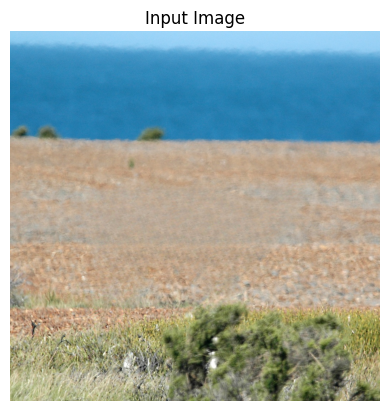

Image Shape  (1023, 1024, 3)


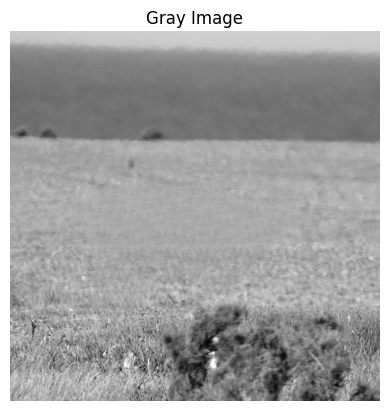

Performing K-means clustering...


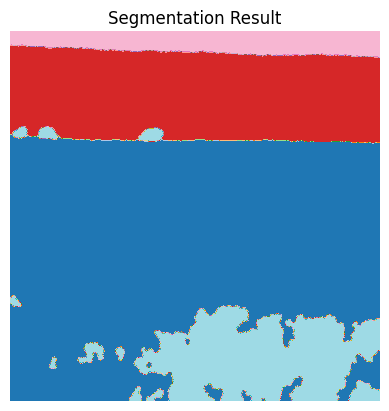

Wavelet Coeffs Shape:  (512, 512, 6)


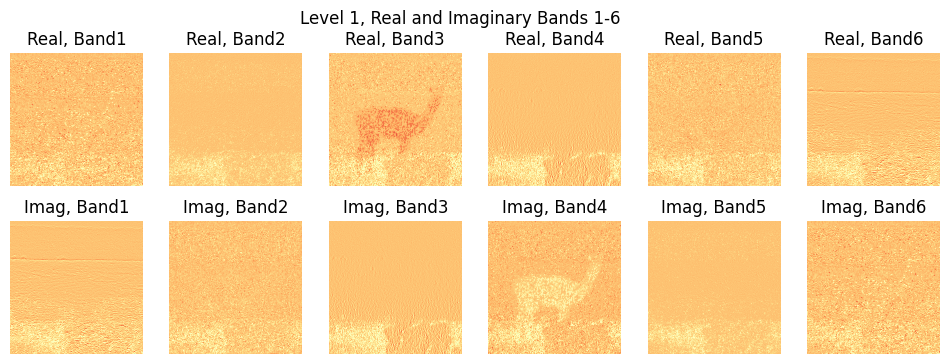

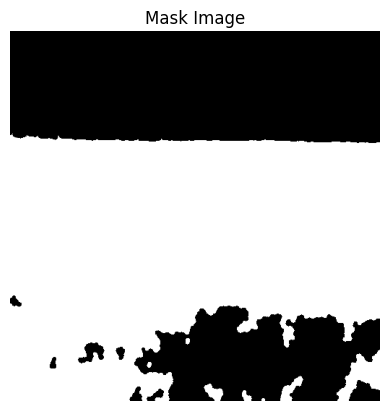

Real Vars:  [0.00030706 0.00080064 0.00347298 0.00164739 0.0010474  0.00071469]
Imag Vars:  [0.00090634 0.0010464  0.00175964 0.00508122 0.00091028 0.00043333]
Real Vars Normalized:  [0.         0.15590405 1.         0.42336323 0.23384805 0.12875619]
Imag Vars Normalized:  [0.10177019 0.13190304 0.2853588  1.         0.10261672 0.        ]
Threshold:  1.0
Picked Bands:
Real 3
Imag 4


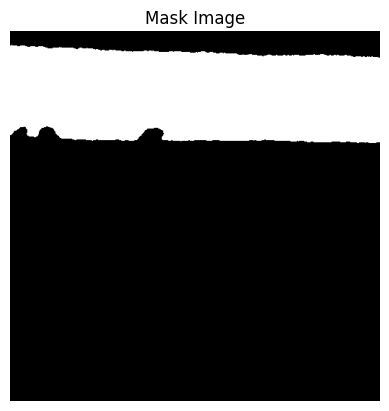

Real Vars:  [1.93302940e-05 2.24645059e-05 2.58046854e-04 9.51149746e-05
 4.56282108e-05 5.30325040e-05]
Imag Vars:  [8.12481127e-05 2.78134282e-05 9.24430710e-05 1.63331239e-05
 2.41354150e-05 2.36850370e-05]
Real Vars Normalized:  [0.         0.01312943 1.         0.31746721 0.11016377 0.14118086]
Imag Vars Normalized:  [0.85291071 0.15083842 1.         0.         0.10251342 0.09659596]
Threshold:  1.0
Picked Bands:
Real 3
Imag 3


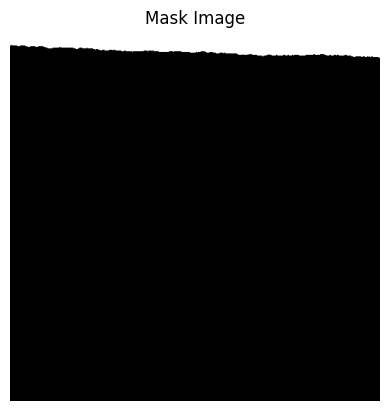

Real Vars:  [7.04675927e-06 1.36504756e-05 5.83018438e-05 2.22618272e-05
 1.98722943e-05 2.52263076e-05]
Imag Vars:  [3.44741245e-05 1.57755776e-05 2.15745751e-05 2.14162320e-06
 1.44132737e-05 8.92754590e-06]
Real Vars Normalized:  [0.         0.12884022 1.         0.29684992 0.25022952 0.35468771]
Imag Vars Normalized:  [1.         0.42167954 0.6010346  0.         0.37954535 0.2098793 ]
Threshold:  1.0
Picked Bands:
Imag 1
Real 3


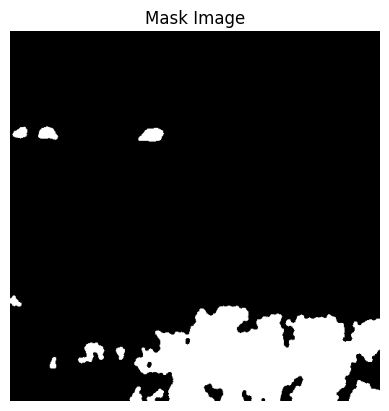

Real Vars:  [1.90148995e-04 7.53919229e-05 3.99010943e-04 5.27588207e-04
 1.45464117e-04 1.59524212e-04]
Imag Vars:  [2.48551855e-04 6.91817034e-05 4.63993273e-04 4.86250338e-04
 7.83730695e-05 1.55291607e-04]
Real Vars Normalized:  [0.25377712 0.         0.7156605  1.         0.15495969 0.18605259]
Imag Vars Normalized:  [0.43007346 0.         0.94663453 1.         0.02203802 0.20646459]
Threshold:  1.0
Picked Bands:
Real 4
Imag 4
Releavant Bands 4 4


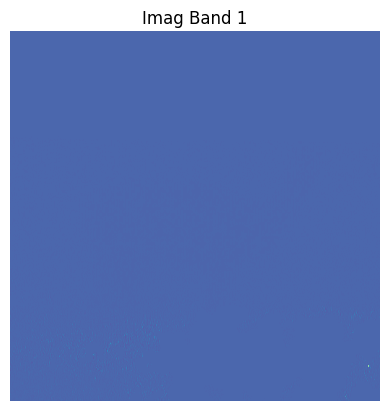

Final Releavant Bands 0 1
No bands available. Adjust threshold maybe.


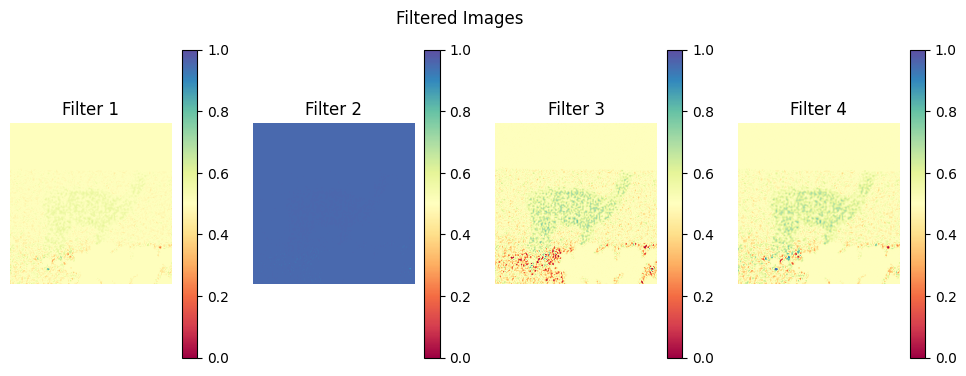

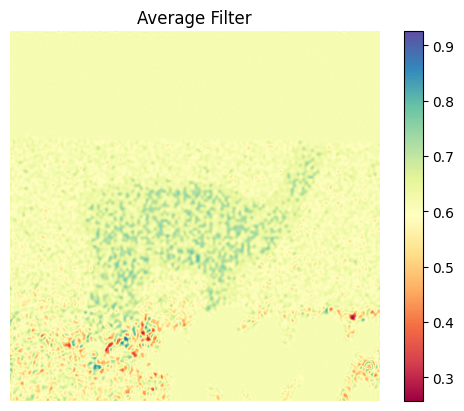

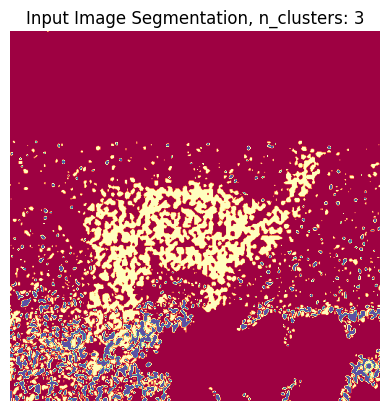

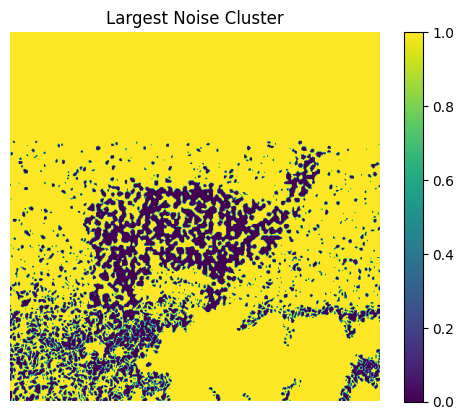

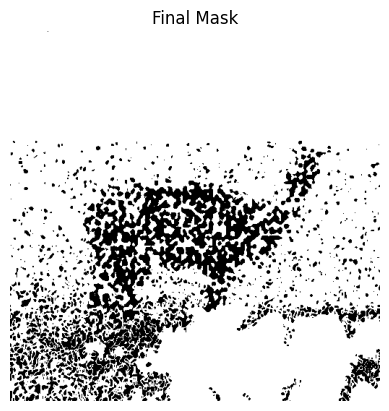

In [88]:
loaded_detections = None
with open("../lama.pkl", "rb") as f:
    loaded_detections = pickle.load(f)

final_mask = detect_inpainting(file_path="../lama.bmp", wavelet_type='dtcwt', output_path="../lama", noise_func=noise_zero, loaded_detections=loaded_detections, kernel_size=5, patch_size=64, var_threshold='dynamic', segmentation_method='kmeans', display=True)

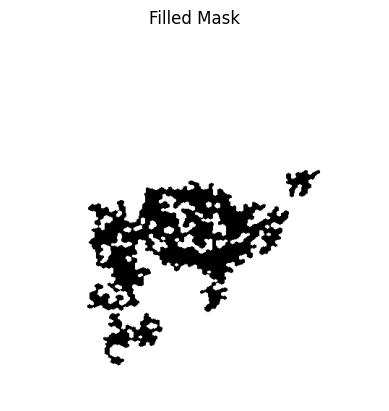

In [89]:
def morph_mask(mask):
    # use cv2 to fill the holes
    mask = mask.astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

    # do opening and closing to remove small noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

    # remove big connected components from the white mask
    mask = morphology.remove_small_objects(mask > 0, min_size=64, connectivity=1).astype(np.uint8)

    # invert the mask and remove small connected components from the black mask and invert it back
    mask = 1 - mask
    mask = morphology.remove_small_objects(mask > 0, min_size=512, connectivity=1).astype(np.uint8)
    mask = 1 - mask

    # open the mask to remove small noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

    return mask


mask = morph_mask(final_mask)
plt.imshow(mask, cmap="gray")
plt.axis('off')
plt.title("Filled Mask")
plt.show()

# Metrics

In [90]:
def calculate_metrics(gt_mask, pred_mask, threshold=0.5):
    # Convert predicted mask to numpy array
    pred_mask = np.array(pred_mask)
    
    # Ensure both masks have the same shape
    if gt_mask.shape != pred_mask.shape:
        raise ValueError("Ground truth and predicted masks must have the same shape.")
    
    # Convert masks to boolean arrays
    gt_mask_bool = gt_mask > threshold
    pred_mask_bool = pred_mask > threshold
    
    # Calculate intersection and union
    intersection = np.logical_and(gt_mask_bool, pred_mask_bool)
    union = np.logical_or(gt_mask_bool, pred_mask_bool)
    
    # Calculate IoU
    union_sum = np.sum(union)
    iou = np.sum(intersection) / union_sum if union_sum > 0 else 1.0
    
    # Calculate accuracy
    accuracy = np.mean(gt_mask_bool == pred_mask_bool)
    
    # Calculate precision and recall
    true_positive = np.sum(intersection)
    false_positive = np.sum(np.logical_and(~gt_mask_bool, pred_mask_bool))
    false_negative = np.sum(np.logical_and(gt_mask_bool, ~pred_mask_bool))
    
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 1.0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 1.0
    
    # Calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return {
        "accuracy": accuracy,
        "iou": iou,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
    }

# # get the ground truth mask
# gt_mask = read_img("/mntdata/avanti/project/ece251c/md_0_paper_mask.png")
# print(gt_mask)

# # downsample the ground truth mask to match the predicted mask size
# gt_mask = gt_mask[::2, ::2]
# gt_mask = gt_mask.mean(axis=2)

# print("Ground Truth Mask Shape: ", gt_mask.shape)

# # print the ground truth mask
# plt.imshow(gt_mask, cmap="gray")
# plt.axis('off')
# plt.title("Ground Truth Mask")
# plt.show()

# # calculate the quality metrics
# metrics = calculate_metrics(gt_mask, morphed_mask)
# print(metrics)
# # print(f"Accuracy: {accuracy:.4f}")
# # print(f"IoU: {iou:.4f}")

# Pipeline To Run All Images and Wavelets

Performing K-means clustering...
Wavelet Coeffs Shape:  (340, 512, 6)
Real Vars:  [0.00110213 0.00128568 0.00204704 0.00113247 0.0011684  0.00084303]
Imag Vars:  [0.00081355 0.00186775 0.0007794  0.00218888 0.00112266 0.00079504]
Real Vars Normalized:  [0.21519749 0.36764383 1.         0.24039801 0.27023967 0.        ]
Imag Vars Normalized:  [0.02423155 0.77216275 0.         1.         0.24353683 0.01109631]
Threshold:  1.0
Picked Bands:
Real 3
Imag 4
Real Vars:  [0.00127888 0.00082509 0.00142372 0.00081252 0.0011977  0.00096706]
Imag Vars:  [0.00087814 0.00121974 0.00069344 0.00071678 0.00094652 0.00111246]
Real Vars Normalized:  [0.76301737 0.02056733 1.         0.         0.63019105 0.25284213]
Imag Vars Normalized:  [0.35095111 1.         0.         0.0443439  0.48087986 0.79617545]
Threshold:  1.0
Picked Bands:
Imag 2
Real 3
Real Vars:  [0.00042355 0.00033565 0.00064378 0.00039727 0.00026892 0.00030986]
Imag Vars:  [0.0003358  0.00056953 0.0003404  0.00028363 0.00033201 0.0003242 

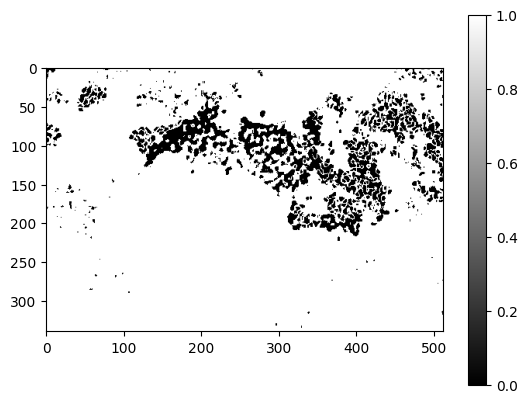

(340, 512) (340, 512)
Performing K-means clustering...
(340, 512)
Wavelet Coeffs Shape:  (340, 512, 3)
Real Vars:  [0.00055152 0.00147757 0.00075139]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [0.         1.         0.21582946]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.803957364193485
Picked Bands:
Real 2
Real Vars:  [0.00071976 0.00124462 0.00079213]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [0.         1.         0.13788453]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.7844711332107791
Picked Bands:
Real 2
Real Vars:  [0.00050033 0.00064832 0.00022835]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [0.64761051 1.         0.        ]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.911902626306278
Picked Bands:
Real 2
Releavant Bands 3 0
Final Releavant Bands 1 0


C:\Users\gsnik\AppData\Local\Temp\ipykernel_2352\2875125316.py:112: RuntimeWarning: invalid value encountered in divide
  imag_vars_norm = (imag_vars - imag_vars.min()) / (imag_vars.max() - imag_vars.min())


No bands available. Adjust threshold maybe.


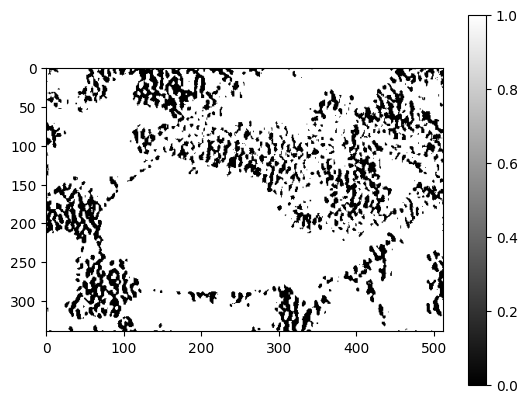

(340, 512) (340, 512)
Performing K-means clustering...
(341, 513)
Wavelet Coeffs Shape:  (341, 513, 3)
Real Vars:  [0.00067565 0.0014706  0.00097588]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [0.         1.         0.37767119]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.8444177974565624
Picked Bands:
Real 2
Real Vars:  [0.00073121 0.00093123 0.0007642 ]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [0.         1.         0.16496132]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.7912403306852074
Picked Bands:
Real 2
Real Vars:  [0.00024672 0.00043243 0.00022361]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [0.11065216 1.         0.        ]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.7776630411952469
Picked Bands:
Real 2
Releavant Bands 3 0
Final Releavant Bands 1 0


C:\Users\gsnik\AppData\Local\Temp\ipykernel_2352\2875125316.py:112: RuntimeWarning: invalid value encountered in divide
  imag_vars_norm = (imag_vars - imag_vars.min()) / (imag_vars.max() - imag_vars.min())


No bands available. Adjust threshold maybe.


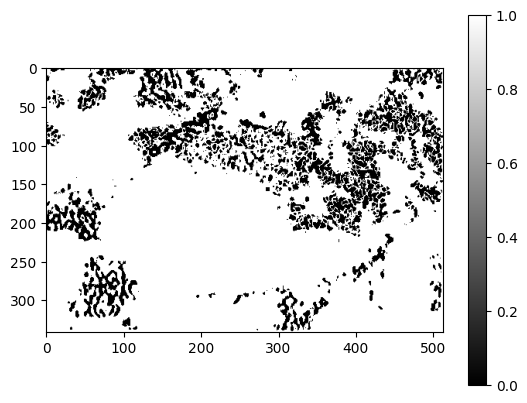

(340, 512) (341, 513)
Performing K-means clustering...
(341, 513)
Wavelet Coeffs Shape:  (341, 513, 3)
Real Vars:  [0.00067565 0.0014706  0.00097588]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [0.         1.         0.37767119]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.8444177974565565
Picked Bands:
Real 2
Real Vars:  [0.00073121 0.00093123 0.0007642 ]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [0.         1.         0.16496132]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.7912403306847016
Picked Bands:
Real 2
Real Vars:  [0.00024672 0.00043243 0.00022361]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [0.11065216 1.         0.        ]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.7776630411953329
Picked Bands:
Real 2
Releavant Bands 3 0
Final Releavant Bands 1 0


C:\Users\gsnik\AppData\Local\Temp\ipykernel_2352\2875125316.py:112: RuntimeWarning: invalid value encountered in divide
  imag_vars_norm = (imag_vars - imag_vars.min()) / (imag_vars.max() - imag_vars.min())


No bands available. Adjust threshold maybe.


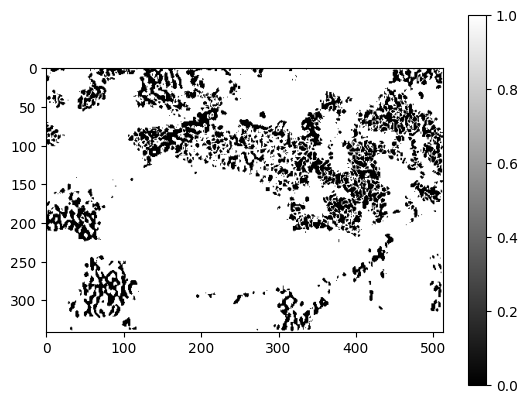

(340, 512) (341, 513)
Performing K-means clustering...
(345, 517)
Wavelet Coeffs Shape:  (345, 517, 3)
Real Vars:  [0.0011585  0.00145182 0.00096722]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [0.39472381 1.         0.        ]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.8486809523799728
Picked Bands:
Real 2
Real Vars:  [0.00093214 0.00085357 0.00077723]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [1.         0.49280109 0.        ]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.8732002721513736
Picked Bands:
Real 1
Real Vars:  [0.00034525 0.00042517 0.00020965]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [0.62916344 1.         0.        ]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.9072908593006229
Picked Bands:
Real 2
Releavant Bands 3 0
Final Releavant Bands 1 0


C:\Users\gsnik\AppData\Local\Temp\ipykernel_2352\2875125316.py:112: RuntimeWarning: invalid value encountered in divide
  imag_vars_norm = (imag_vars - imag_vars.min()) / (imag_vars.max() - imag_vars.min())


No bands available. Adjust threshold maybe.


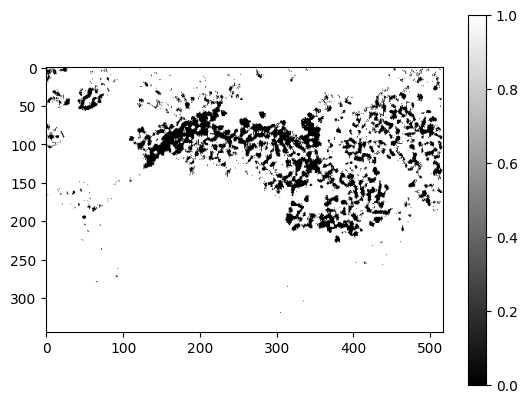

(340, 512) (345, 517)


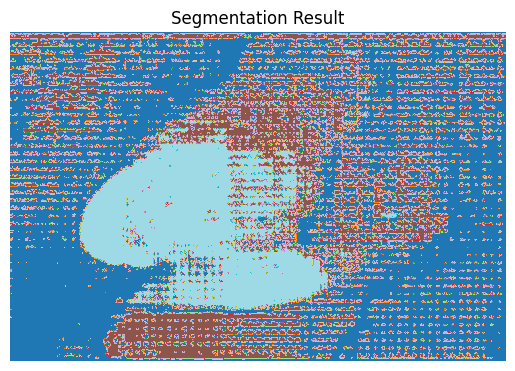

Wavelet Coeffs Shape:  (340, 512, 6)
Real Vars:  [0.0023778  0.00196453 0.00242082 0.00208079 0.00191871 0.00168751]
Imag Vars:  [0.00169597 0.0033621  0.00160524 0.00212703 0.00189663 0.00195799]
Real Vars Normalized:  [0.94133437 0.37776104 1.         0.53631369 0.31527828 0.        ]
Imag Vars Normalized:  [0.05164818 1.         0.         0.2970012  0.16585844 0.20078514]
Threshold:  1.0
Picked Bands:
Imag 2
Real 3
Real Vars:  [0.00046356 0.0004021  0.00138359 0.00041953 0.00048613 0.00033366]
Imag Vars:  [0.00030663 0.00063644 0.00031383 0.00088869 0.00050858 0.00037147]
Real Vars Normalized:  [0.12372925 0.06518914 1.         0.08178944 0.14522136 0.        ]
Imag Vars Normalized:  [0.         0.56663204 0.01236237 1.         0.34696484 0.11140262]
Threshold:  1.0
Picked Bands:
Real 3
Imag 4
Real Vars:  [0.00017038 0.000186   0.00029459 0.00020331 0.0001646  0.00017657]
Imag Vars:  [0.00018503 0.0002703  0.00016683 0.00011928 0.00017887 0.00013172]
Real Vars Normalized:  [0.04452

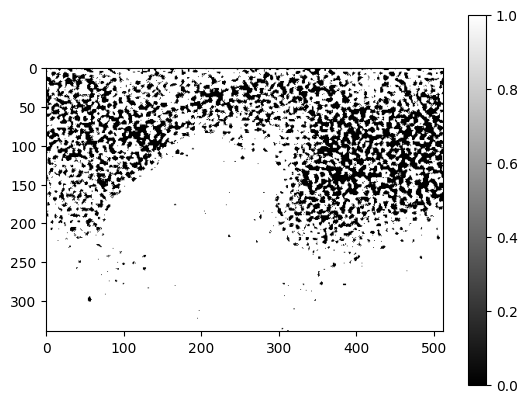

(340, 512) (340, 512)


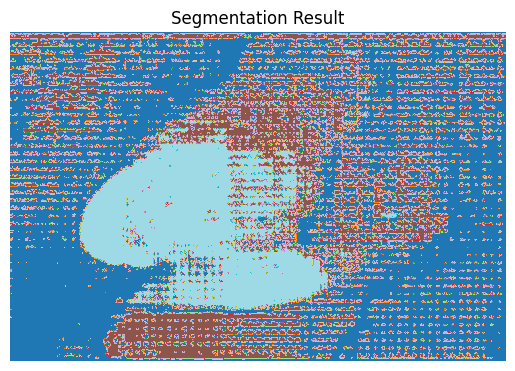

(340, 512)
Wavelet Coeffs Shape:  (340, 512, 3)
Real Vars:  [0.00126613 0.00243316 0.00135731]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [0.         1.         0.07813648]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.7695341200014534
Picked Bands:
Real 2
Real Vars:  [0.00032203 0.00074248 0.00034923]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [0.         1.         0.06469009]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.766172522073666
Picked Bands:
Real 2
Real Vars:  [0.00023507 0.00027612 0.00013148]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [0.71622522 1.         0.        ]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.9290563046011192
Picked Bands:
Real 2
Releavant Bands 3 0
Final Releavant Bands 1 0
No bands available. Adjust threshold maybe.


C:\Users\gsnik\AppData\Local\Temp\ipykernel_2352\2875125316.py:112: RuntimeWarning: invalid value encountered in divide
  imag_vars_norm = (imag_vars - imag_vars.min()) / (imag_vars.max() - imag_vars.min())


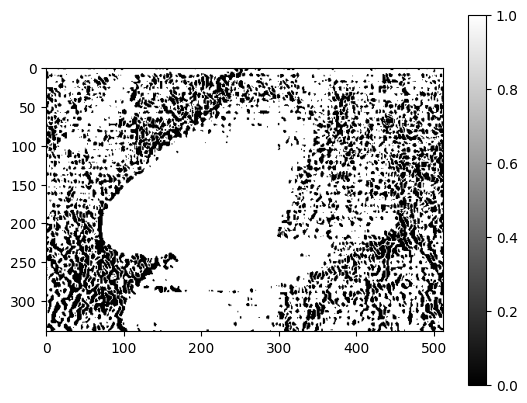

(340, 512) (340, 512)


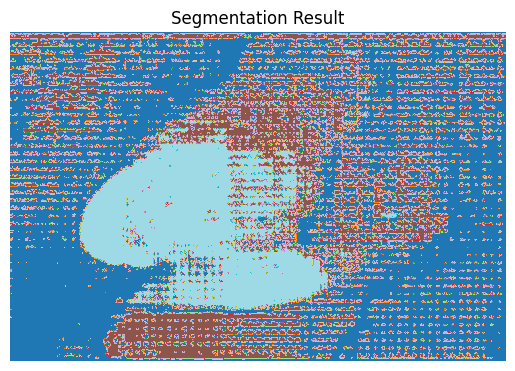

(341, 513)
Wavelet Coeffs Shape:  (341, 513, 3)
Real Vars:  [0.00137189 0.00205799 0.00142289]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [0.         1.         0.07433168]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.768582921117219
Picked Bands:
Real 2
Real Vars:  [0.0002679  0.00060388 0.0003461 ]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [0.         1.         0.23275687]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.8081892185042097
Picked Bands:
Real 2
Real Vars:  [0.00010993 0.00022602 0.00013544]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [0.        1.        0.2197587]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.8049396744926103
Picked Bands:
Real 2
Releavant Bands 3 0
Final Releavant Bands 1 0


C:\Users\gsnik\AppData\Local\Temp\ipykernel_2352\2875125316.py:112: RuntimeWarning: invalid value encountered in divide
  imag_vars_norm = (imag_vars - imag_vars.min()) / (imag_vars.max() - imag_vars.min())


No bands available. Adjust threshold maybe.


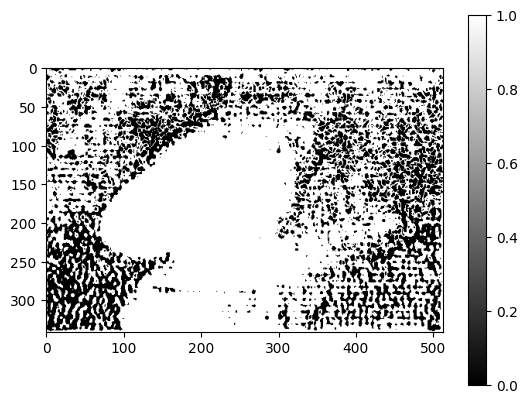

(340, 512) (341, 513)


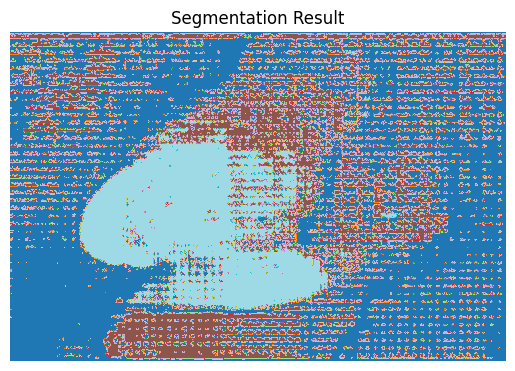

(341, 513)
Wavelet Coeffs Shape:  (341, 513, 3)
Real Vars:  [0.00137189 0.00205799 0.00142289]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [0.         1.         0.07433168]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.7685829211169459
Picked Bands:
Real 2
Real Vars:  [0.0002679  0.00060388 0.0003461 ]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [0.         1.         0.23275687]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.8081892185040755
Picked Bands:
Real 2
Real Vars:  [0.00010993 0.00022602 0.00013544]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [0.        1.        0.2197587]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.8049396744926504
Picked Bands:
Real 2
Releavant Bands 3 0
Final Releavant Bands 1 0


C:\Users\gsnik\AppData\Local\Temp\ipykernel_2352\2875125316.py:112: RuntimeWarning: invalid value encountered in divide
  imag_vars_norm = (imag_vars - imag_vars.min()) / (imag_vars.max() - imag_vars.min())


No bands available. Adjust threshold maybe.


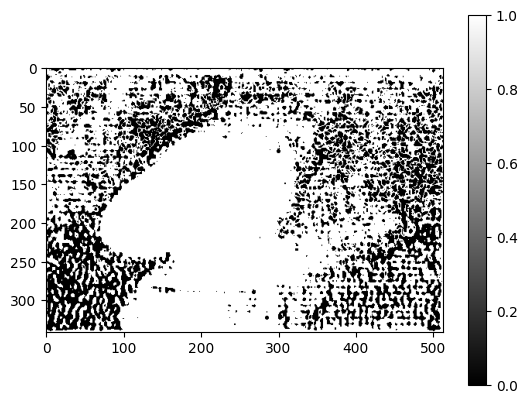

(340, 512) (341, 513)


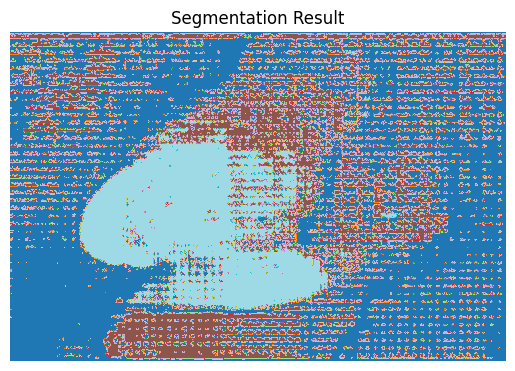

(345, 517)
Wavelet Coeffs Shape:  (345, 517, 3)
Real Vars:  [0.00216587 0.00180232 0.00131387]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [1.         0.57328995 0.        ]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.8933224869729827
Picked Bands:
Real 1
Real Vars:  [0.0003274  0.00071245 0.00037604]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [0.         1.         0.12631746]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.7815793658207071
Picked Bands:
Real 2
Real Vars:  [0.00015444 0.00020568 0.00012677]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [0.35063948 1.         0.        ]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.8376598699192036
Picked Bands:
Real 2
Releavant Bands 3 0
Final Releavant Bands 1 0


C:\Users\gsnik\AppData\Local\Temp\ipykernel_2352\2875125316.py:112: RuntimeWarning: invalid value encountered in divide
  imag_vars_norm = (imag_vars - imag_vars.min()) / (imag_vars.max() - imag_vars.min())


No bands available. Adjust threshold maybe.


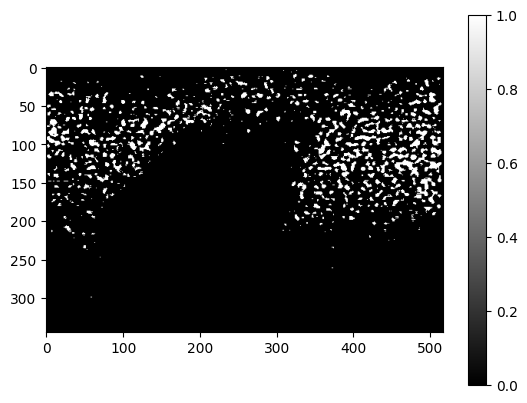

(340, 512) (345, 517)
Performing K-means clustering...
Wavelet Coeffs Shape:  (340, 512, 6)
Real Vars:  [6.97129091e-05 3.92923907e-05 3.63438690e-05 7.85762313e-05
 5.22460357e-05 3.22587109e-05]
Imag Vars:  [3.77940119e-05 6.60577583e-05 7.79606826e-05 5.07611955e-05
 4.19031162e-05 5.35635202e-05]
Real Vars Normalized:  [0.80863997 0.15185787 0.08819898 1.         0.43152839 0.        ]
Imag Vars Normalized:  [0.         0.70366167 1.         0.32283441 0.10230134 0.39260183]
Threshold:  1.0
Picked Bands:
Imag 3
Real 4
Real Vars:  [0.00098231 0.0004194  0.0005036  0.00048264 0.00051082 0.00061667]
Imag Vars:  [0.00055266 0.00060768 0.00035068 0.00039951 0.00048355 0.00084273]
Real Vars Normalized:  [1.         0.         0.14956887 0.11234435 0.16240431 0.35044562]
Imag Vars Normalized:  [0.41049088 0.52229037 0.         0.09923708 0.27003075 1.        ]
Threshold:  1.0
Picked Bands:
Real 1
Imag 6
Real Vars:  [0.00308391 0.00195801 0.00170345 0.00156185 0.00221471 0.00119963]
Imag V

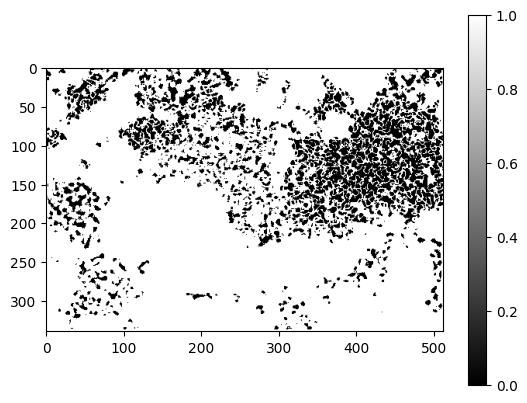

(340, 512) (340, 512)
Performing K-means clustering...
(340, 512)
Wavelet Coeffs Shape:  (340, 512, 3)
Real Vars:  [6.82640698e-05 4.62815363e-05 4.26113490e-05]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [1.         0.14307205 0.        ]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.785768011874202
Picked Bands:
Real 1
Real Vars:  [0.00061478 0.0006088  0.00035523]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [1.         0.97698543 0.        ]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.9942463578688384
Picked Bands:
Real 1
Real Vars:  [0.00132305 0.00159482 0.00135313]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [0.        1.        0.1106907]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.777672675815803
Picked Bands:
Real 2
Real Vars:  [0.00015202 0.00017737 0.0001142 ]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [0.59874709 1.         0.        ]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.8996867718136097
Picked Bands:
Real 2
Releavant Bands 4 0
Final Releavant Bands 1 0


C:\Users\gsnik\AppData\Local\Temp\ipykernel_2352\2875125316.py:112: RuntimeWarning: invalid value encountered in divide
  imag_vars_norm = (imag_vars - imag_vars.min()) / (imag_vars.max() - imag_vars.min())


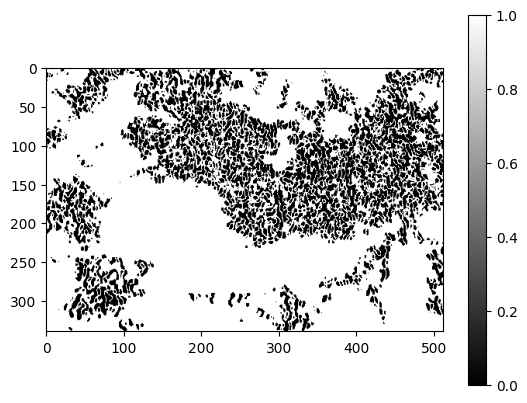

(340, 512) (340, 512)
Performing K-means clustering...
(341, 513)
Wavelet Coeffs Shape:  (341, 513, 3)
Real Vars:  [4.03979407e-05 2.81611957e-05 4.16398172e-05]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [0.90786324 0.         1.        ]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.976965810148827
Picked Bands:
Real 3
Real Vars:  [0.00056445 0.00041708 0.00034615]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [1.         0.32490526 0.        ]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.8312263142750025
Picked Bands:
Real 1
Real Vars:  [0.00166871 0.00128648 0.00161872]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [1.         0.         0.86923265]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.9673081634903216
Picked Bands:
Real 1
Real Vars:  [0.00012337 0.0001013  0.00010601]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [1.         0.         0.21321376]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.8033034406020864
Picked Bands:
Real 1
Releavant Bands 4 0
Final Releavant Bands 

C:\Users\gsnik\AppData\Local\Temp\ipykernel_2352\2875125316.py:112: RuntimeWarning: invalid value encountered in divide
  imag_vars_norm = (imag_vars - imag_vars.min()) / (imag_vars.max() - imag_vars.min())


No bands available. Adjust threshold maybe.


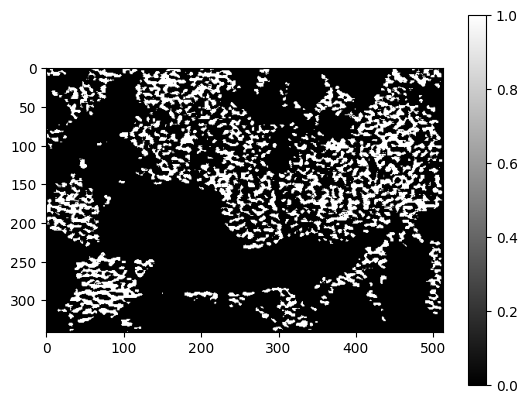

(340, 512) (341, 513)
Performing K-means clustering...
(341, 513)
Wavelet Coeffs Shape:  (341, 513, 3)
Real Vars:  [4.03979407e-05 2.81611957e-05 4.16398172e-05]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [0.90786324 0.         1.        ]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.9769658101497631
Picked Bands:
Real 3
Real Vars:  [0.00056445 0.00041708 0.00034615]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [1.         0.32490526 0.        ]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.831226314274956
Picked Bands:
Real 1
Real Vars:  [0.00166871 0.00128648 0.00161872]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [1.         0.         0.86923265]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.9673081634899877
Picked Bands:
Real 1
Real Vars:  [0.00012337 0.0001013  0.00010601]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [1.         0.         0.21321376]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.8033034406019858
Picked Bands:
Real 1
Releavant Bands 4 0
Final Releavant Bands 

C:\Users\gsnik\AppData\Local\Temp\ipykernel_2352\2875125316.py:112: RuntimeWarning: invalid value encountered in divide
  imag_vars_norm = (imag_vars - imag_vars.min()) / (imag_vars.max() - imag_vars.min())


No bands available. Adjust threshold maybe.


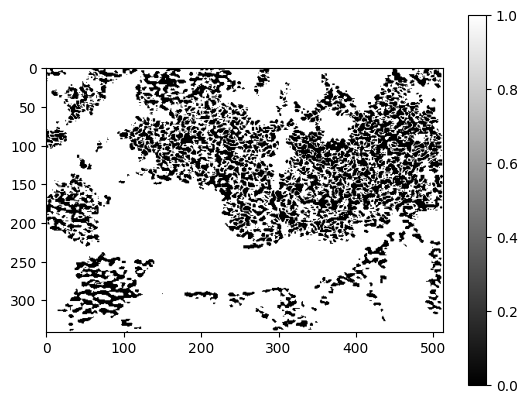

(340, 512) (341, 513)
Performing K-means clustering...
(345, 517)
Wavelet Coeffs Shape:  (345, 517, 3)
Real Vars:  [7.22245456e-05 6.76657778e-05 8.52466483e-05]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [0.25930273 0.         1.        ]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.8148256835693917
Picked Bands:
Real 3
Real Vars:  [0.00068272 0.00028839 0.00031955]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [1.         0.         0.07903257]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.7697581429340805
Picked Bands:
Real 1
Real Vars:  [0.00230967 0.00109645 0.00160972]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [1.         0.         0.42306508]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.8557662689652036
Picked Bands:
Real 1
Real Vars:  [2.19517360e-04 8.73228641e-05 1.00652029e-04]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [1.         0.         0.10082995]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.7752074879808677
Picked Bands:
Real 1
Releavant Bands 4 0
Final Rel

C:\Users\gsnik\AppData\Local\Temp\ipykernel_2352\2875125316.py:112: RuntimeWarning: invalid value encountered in divide
  imag_vars_norm = (imag_vars - imag_vars.min()) / (imag_vars.max() - imag_vars.min())


No bands available. Adjust threshold maybe.


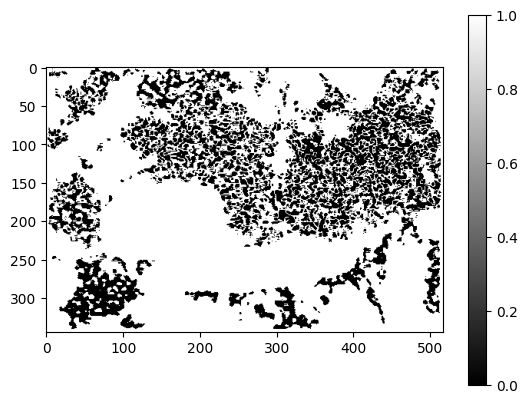

(340, 512) (345, 517)


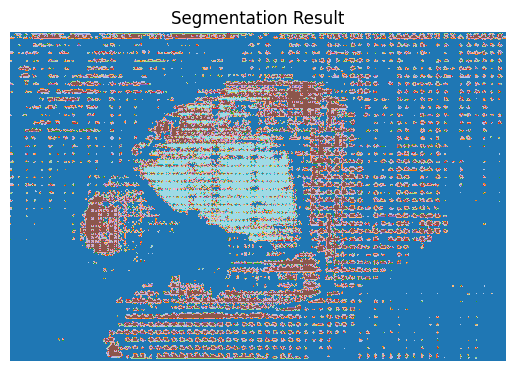

Wavelet Coeffs Shape:  (340, 512, 6)
Real Vars:  [0.00388782 0.0027671  0.00217412 0.00248379 0.00294676 0.00221828]
Imag Vars:  [0.00219565 0.00460468 0.00171529 0.00290053 0.00294699 0.00328146]
Real Vars Normalized:  [1.         0.34602599 0.         0.18070487 0.45085814 0.02576889]
Imag Vars Normalized:  [0.16624721 1.         0.         0.41020424 0.42628387 0.54204203]
Threshold:  1.0
Picked Bands:
Real 1
Imag 2
Real Vars:  [0.00059317 0.00011423 0.00031679 0.00018808 0.00013905 0.0001159 ]
Imag Vars:  [1.40253051e-04 2.08901507e-04 1.67690766e-04 1.32767504e-04
 9.99631815e-05 4.50854877e-04]
Real Vars Normalized:  [1.         0.         0.42292686 0.15418867 0.05181327 0.00347285]
Imag Vars Normalized:  [0.11482138 0.3104614  0.19301564 0.09348845 0.         1.        ]
Threshold:  1.0
Picked Bands:
Real 1
Imag 6
Real Vars:  [5.83879891e-05 1.41382030e-05 3.92287203e-05 1.33069841e-05
 4.71573811e-05 8.42306120e-06]
Imag Vars:  [1.28508888e-05 5.28527370e-06 8.45257137e-06 1.0

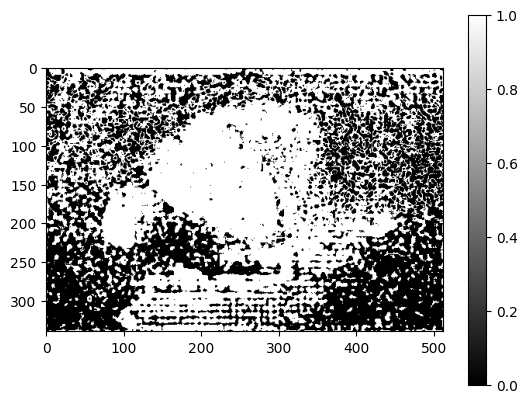

(340, 512) (340, 512)


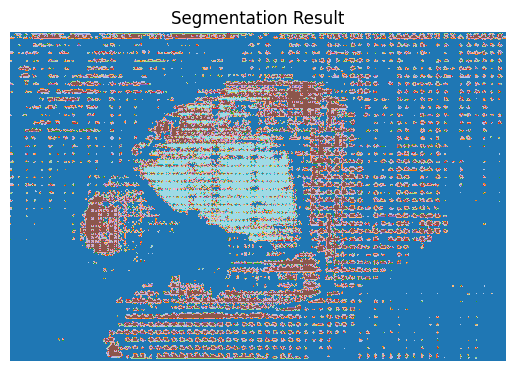

(340, 512)
Wavelet Coeffs Shape:  (340, 512, 3)
Real Vars:  [0.00208189 0.00240649 0.00201603]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [0.1686821 1.        0.       ]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.7921705240963373
Picked Bands:
Real 2
Real Vars:  [3.08405908e-04 2.83771273e-04 9.77591746e-05]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [1.         0.88305238 0.        ]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.9707630938526645
Picked Bands:
Real 1
Real Vars:  [3.39185954e-05 5.21481059e-05 8.28729219e-06]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [0.5843782 1.        0.       ]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.8960945491708281
Picked Bands:
Real 2
Releavant Bands 3 0
Final Releavant Bands 1 0


C:\Users\gsnik\AppData\Local\Temp\ipykernel_2352\2875125316.py:112: RuntimeWarning: invalid value encountered in divide
  imag_vars_norm = (imag_vars - imag_vars.min()) / (imag_vars.max() - imag_vars.min())


No bands available. Adjust threshold maybe.


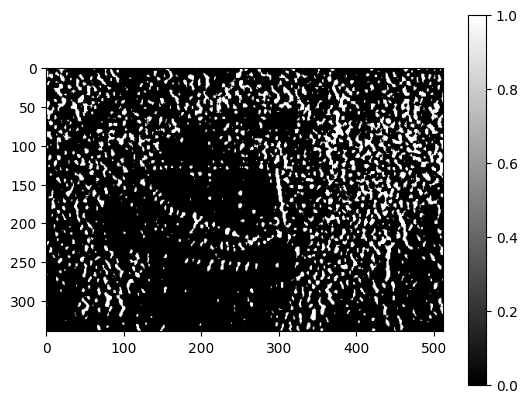

(340, 512) (340, 512)


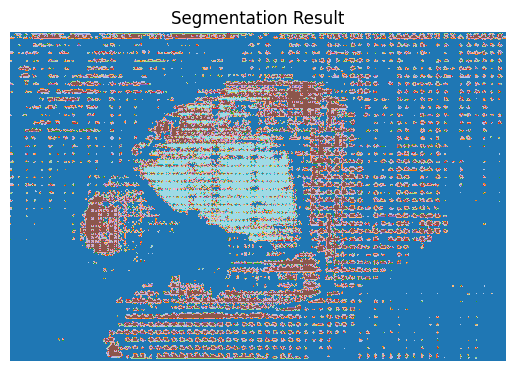

(341, 513)
Wavelet Coeffs Shape:  (341, 513, 3)
Real Vars:  [0.00216817 0.00183841 0.00215126]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [1.         0.         0.94871105]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.987177762706224
Picked Bands:
Real 1
Real Vars:  [3.26088067e-04 1.66472187e-04 9.48735240e-05]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [1.         0.30966332 0.        ]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.8274158300407346
Picked Bands:
Real 1
Real Vars:  [4.35054295e-05 4.06048110e-05 3.22001957e-05]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [1.         0.74342694 0.        ]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.935856734474218
Picked Bands:
Real 1
Releavant Bands 3 0
Final Releavant Bands 1 0


C:\Users\gsnik\AppData\Local\Temp\ipykernel_2352\2875125316.py:112: RuntimeWarning: invalid value encountered in divide
  imag_vars_norm = (imag_vars - imag_vars.min()) / (imag_vars.max() - imag_vars.min())


No bands available. Adjust threshold maybe.


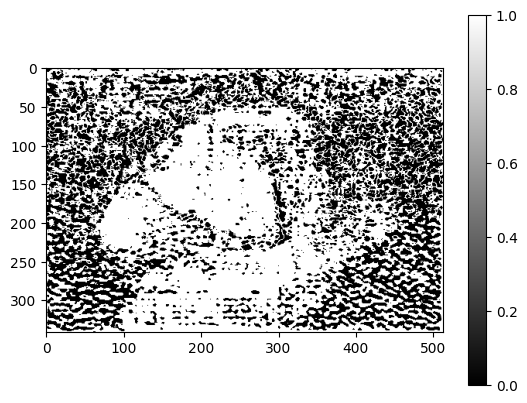

(340, 512) (341, 513)


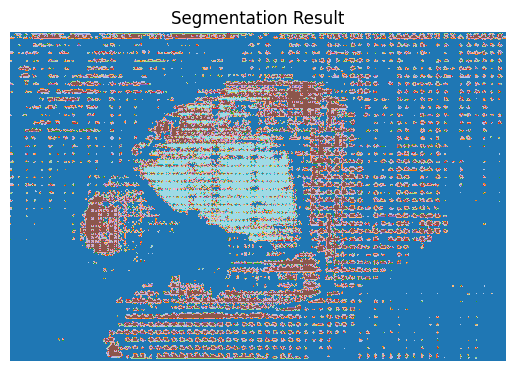

(341, 513)
Wavelet Coeffs Shape:  (341, 513, 3)
Real Vars:  [0.00216817 0.00183841 0.00215126]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [1.         0.         0.94871105]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.9871777627053032
Picked Bands:
Real 1
Real Vars:  [3.26088067e-04 1.66472187e-04 9.48735240e-05]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [1.         0.30966332 0.        ]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.8274158300407257
Picked Bands:
Real 1
Real Vars:  [4.35054295e-05 4.06048110e-05 3.22001957e-05]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [1.         0.74342694 0.        ]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.9358567344736997
Picked Bands:
Real 1
Releavant Bands 3 0
Final Releavant Bands 1 0


C:\Users\gsnik\AppData\Local\Temp\ipykernel_2352\2875125316.py:112: RuntimeWarning: invalid value encountered in divide
  imag_vars_norm = (imag_vars - imag_vars.min()) / (imag_vars.max() - imag_vars.min())


No bands available. Adjust threshold maybe.


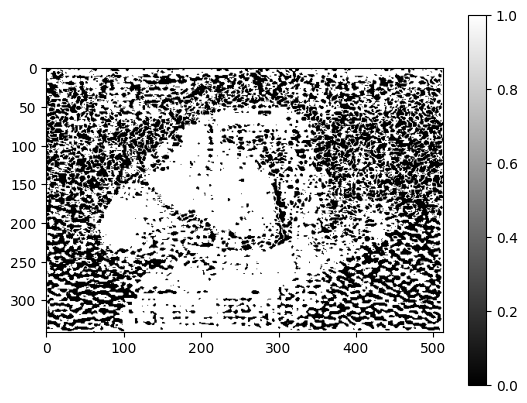

(340, 512) (341, 513)


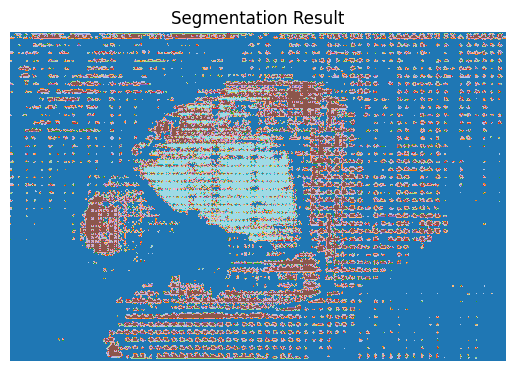

(345, 517)
Wavelet Coeffs Shape:  (345, 517, 3)
Real Vars:  [0.00318347 0.00168318 0.00205461]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [1.         0.         0.24757116]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.8118927902410504
Picked Bands:
Real 1
Real Vars:  [4.21315025e-04 1.10875729e-04 9.55702656e-05]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [1.         0.04698606 0.        ]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.7617465151265219
Picked Bands:
Real 1
Real Vars:  [6.07563004e-05 1.95541133e-05 1.95591355e-05]
Imag Vars:  [0. 0. 0.]
Real Vars Normalized:  [1.00000000e+00 0.00000000e+00 1.21891906e-04]
Imag Vars Normalized:  [0 0 0]
Threshold:  0.7500304729765381
Picked Bands:
Real 1
Releavant Bands 3 0
Final Releavant Bands 1 0
No bands available. Adjust threshold maybe.


C:\Users\gsnik\AppData\Local\Temp\ipykernel_2352\2875125316.py:112: RuntimeWarning: invalid value encountered in divide
  imag_vars_norm = (imag_vars - imag_vars.min()) / (imag_vars.max() - imag_vars.min())


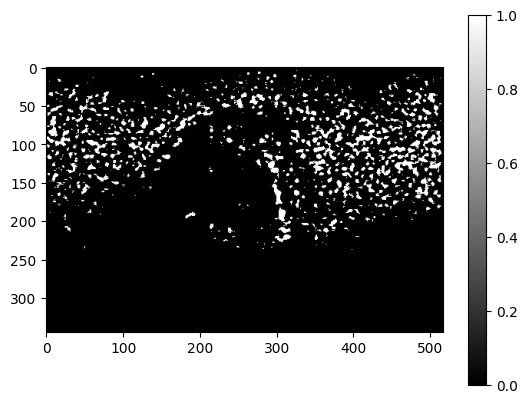

(340, 512) (345, 517)
Data saved to ../result.csv


In [ ]:
wavelets = ['dtcwt', 'haar', 'sym2', 'db2', 'coif2']
inpainting_methods = ['lama', 'mat']
segmentation_methods = ['kmeans', 'sam']
metrics = [["File Path", "Wavelet", "Inpainting", "Segmentation", "Accuracy", "IOU", "Precision", "Recall", "F1 score"]]

image_dir = "../data/images"
for ip_method in inpainting_methods:
    inpainted_dir = f"../data/inpainted/{ip_method}"                # Change Here
    pickle_dir = f"../data/{ip_method}_pkl"                         # Change Here
    mask_dir = f"../data/masks"                                     # Change Here

    for seg_method in segmentation_methods:
        imgs = os.listdir(image_dir)[:1]

        for img_with_extension in imgs:
            img = img_with_extension.split(".")[0]
            inpainted_path = f"{inpainted_dir}/{img}_altered.bmp"       # Change Here      
            mask_path = f"{mask_dir}/{img}.png"                         # Change Here
            pickle_filepath = f"{pickle_dir}/{img}_altered_filtered.pkl"     # Change Here

            loaded_detections = None
            with open(pickle_filepath, "rb") as f:
                loaded_detections = pickle.load(f)

            for wavelet in wavelets:
                output_dir = f"../data/output/{img}"
                output_file_prefix = f"{ip_method}_{seg_method}_{wavelet}"
                os.makedirs(output_dir, exist_ok=True)
                # Get output mask
                output_mask = detect_inpainting(
                    file_path=inpainted_path, 
                    wavelet_type=wavelet, 
                    output_path = f"{output_dir}/{output_file_prefix}",
                    noise_func=noise_zero, 
                    loaded_detections=loaded_detections, 
                    patch_size=64, 
                    var_threshold='dynamic', 
                    kernel_size=5, 
                    segmentation_method=seg_method, 
                    display=False) # TODO: add image id
                
                after_morph_mask = morph_mask(output_mask)

                output_mask_temp = (output_mask > 0.5).astype(np.uint8)
                im = Image.fromarray(output_mask_temp * 255)
                im.save(f"{output_dir}/{output_file_prefix}_pre_morph.png")

                # plt.imshow(output_mask, cmap="gray")
                # plt.colorbar()
                # plt.show()

                im = Image.fromarray(after_morph_mask * 255)
                im.save(f"{output_dir}/{output_file_prefix}_final_mask.png") 

                # Read GT mask
                gt_mask = read_img(mask_path)
                gt_mask = gt_mask[::2, ::2]
                gt_mask = gt_mask.mean(axis=2)

                print(gt_mask.shape, output_mask.shape)

                extra_height = output_mask.shape[0] - gt_mask.shape[0]
                extra_width = output_mask.shape[1] - gt_mask.shape[1]
                output_mask = output_mask[extra_height:, extra_width:]

                # Compute Metrics on it
                computed_metrics = calculate_metrics(gt_mask, output_mask, threshold=0.5)
                computed_metrics = [img, wavelet, ip_method, seg_method] + [value for value in computed_metrics.values()]

                metrics.append(computed_metrics)

result_path = "../result.csv"
with open(result_path, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(metrics)

print(f"Data saved to {result_path}")

In [ ]:
# import os

# def rename_files_in_folder(folder_path):
#     try:
#         # List all files in the folder
#         files = os.listdir(folder_path)
        
#         for file_name in files:
#             # Check if the file follows the naming convention
#             if file_name.endswith('.png') and len(file_name.split('_')) > 1:
#                 # Extract the new name
#                 new_name = file_name.split('_')[0] + '.png'
                
#                 # Define the full paths
#                 old_file_path = os.path.join(folder_path, file_name)
#                 new_file_path = os.path.join(folder_path, new_name)
                
#                 # Rename the file
#                 os.rename(old_file_path, new_file_path)
#                 print(f'Renamed: {file_name} -> {new_name}')
#     except Exception as e:
#         print(f"An error occurred: {e}")

# # Specify the folder path containing the images
# folder_path = "../data/masks"

# # Call the function to rename files
# rename_files_in_folder(folder_path)


Renamed: 004a30a1ca460088_m0_cp5_18ee4b1c.png -> 004a30a1ca460088.png
Renamed: 005589a94cadf725_m0cnyhnx_5dcca1f0.png -> 005589a94cadf725.png
Renamed: 0069e8be6d4f66f0_m01nkt_b289f59a.png -> 0069e8be6d4f66f0.png
Renamed: 00f3addd05a6f8e8_m03bbps_1c87b9cc.png -> 00f3addd05a6f8e8.png
Renamed: 015c309ce859052e_m052sf_5a0c39cd.png -> 015c309ce859052e.png
Renamed: 015e65bb33ee3e0e_m08pbxl_df6e098e.png -> 015e65bb33ee3e0e.png
Renamed: 01cc041f0962d41c_m06j2d_5e8669bb.png -> 01cc041f0962d41c.png
Renamed: 01d831fbda6fa27e_m015p6_346407c6.png -> 01d831fbda6fa27e.png
Renamed: 02682a455ece74dd_m09ld4_7d26450a.png -> 02682a455ece74dd.png
Renamed: 0274c6ca36923bbf_m015p6_4e1957be.png -> 0274c6ca36923bbf.png
Renamed: 03052f35d170935d_m03fwl_bdbe7458.png -> 03052f35d170935d.png
Renamed: 036cf898c6176afd_m01h8tj_43921594.png -> 036cf898c6176afd.png
Renamed: 039beb511fd1e7f7_m01yrx_5772a209.png -> 039beb511fd1e7f7.png
Renamed: 0438c2d3613680bf_m018xm_2873bb67.png -> 0438c2d3613680bf.png
Renamed: 04ec76